In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import integrate
from scipy.optimize import fsolve

from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
from ligo.skymap.io import fits
import healpy as hp

import os
from os import listdir
from os.path import isfile, join

from multiprocessing import Pool
import time

import sys
from tqdm import tqdm

H0GLOB=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoflag = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)

In [2]:
#-----------------Functions--------------------------
def z_from_dL(dL_val):
    '''
    Returns redshift for a given luminosity distance dL (in Mpc)'''
    
    func = lambda z :cosmoflag.luminosity_distance(z).value - dL_val
    z = fsolve(func, 0.77)
    return z[0]
def z_from_dcom(dc_val):
    '''
    Returns redshift for a given comoving distance dc (in Mpc)'''
    
    func = lambda z :cosmoflag.comoving_distance(z).value - dc_val
    z = fsolve(func, 0.77)
    return z[0]

def Mises_Fisher(theta,phi,DS_theta,DS_phi,conc):
    meanvec=hp.ang2vec(DS_theta,DS_phi)
    meanvec=np.asarray(meanvec,dtype=np.float128)
    norm=np.sqrt(np.dot(meanvec,meanvec))
    meanvec=meanvec/norm
    
    var=hp.ang2vec(theta,phi)
    var=np.asarray(var,dtype=np.float128)
    norm=np.sqrt(np.dot(var,var))
    var=var/norm
    
    factor=np.dot(conc*var,meanvec)
    factor=np.float128(factor)
    #Normalization is futile, we will devide by the sum
    #fullnorm=conc/(2*np.pi*(np.exp(conc)-np.exp(-conc)))
    ret=np.float128(np.exp(factor))#/fullnorm
    #ret=factor
    return ret

def sphere_uncorr_gauss(x,y,mux,muy,sigx,sigy):
    #correlation is 0 so is a multiplication of two gaussians
    #x is theta, y is phi
    #meanvec=(mux,muy)
    meanvec=np.asarray((1,mux,muy))
    norm=np.sqrt(np.dot(meanvec,meanvec))
    meanvec=meanvec/norm
    
    #var=(x,y)
    var=np.asarray((1,x,y))
    norm=np.sqrt(np.dot(var,var))
    var=var/norm
    
    diff=meanvec-var
    diff_len=np.sqrt(np.dot(diff,diff))
    #xfactor=((x-mux)/sigx)**2
    #yfactor=((y*(1-np.sin(y))-muy*(1-np.sin(muy)))/sigy)**2
    #yfactor=((y-muy)/sigy)**2
    #norm=2*np.pi*sigx*sigy
    factor=((diff_len)/sigy)**2
    ret=np.exp(-(1/2)*(factor))#/norm
    #ret=np.exp(-1/2*(xfactor+yfactor))
    return ret

def beta_line(galaxies,z0,z1,zmax):
    denom=len(galaxies[(galaxies>=z0)*(galaxies<=z1)])
    num=len(galaxies[galaxies<=zmax])
    ret=num/denom
    return ret
def normalisation(galaxies,zmax):
    #is a beta after some simplification with the likelihood
    #cat must be complete, omega must be a constant we set that all to 1
    ret=len(galaxies[galaxies<=zmax])
    return ret

def likelihood_line(mu,dl,k=0.1):
    sigma=k*mu
    norm=1/(np.sqrt(2*np.pi)*sigma)
    body=np.exp(-((dl-mu)**2)/(2*sigma**2))
    ret=norm*body
    return ret



In [22]:
#-----------------Parameter setting--------------------------------
H0min=30
H0max=140
H0Grid=np.linspace(H0min,H0max,1000)
nsamp=1500000
z_inf_cat=0.79
z_sup_cat=2
dcom_min=cosmoflag.comoving_distance(z_inf_cat).value
dcom_max=cosmoflag.comoving_distance(z_sup_cat).value


dl_min=cosmoflag.luminosity_distance(z_inf_cat).value
dl_max=cosmoflag.luminosity_distance(z_sup_cat).value
betaHomdMax =15978.6#(dl_max-dl_min)/2#15978.6#max dl
#---------angular stuff------------------
fisher=0
#------meses-fisher-------------------------
if fisher==1:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    conc=1/(sigma_phi**2)
    print('Fisher concentration Parameter k={}'.format(conc))
    print('Sigma phi={}°,Sigma theta={}°'.format(sigma_deg,sigma_deg))
else:
    #-----------Gaussian-----------------------------------
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    radius_rad=np.radians(circle_deg)
    print('Sigma phi={}°,Sigma theta={}°'.format(sigma_deg,sigma_deg))


phi_min=0
phi_max=phi_min+5*sigma_phi
theta_min=0
theta_max=theta_min+5*sigma_theta#depends on the arccos 0 to 1 is from pi/2 to 0 -1 to 1 is full range

s=0.1
DS_z=1.2
DS_phi=(phi_max-phi_min)/2
DS_theta=(theta_max-theta_min)/2

Sigma phi=0.8410441740067199°,Sigma theta=0.8410441740067199°


In [4]:
#------------------points generator------------------
u = np.random.uniform(0,1,size=nsamp) # uniform random vector of size nsamp
dc_gals_all     = np.cbrt((u*0**3)+((1-u)*dcom_max**3))
#dc_gals_all     = (u*dcom_min)+(1-u)*dcom_max
phi_gals   = np.random.uniform(phi_min,phi_max,nsamp)
theta_gals = np.arccos( np.random.uniform(np.cos(theta_max),1,nsamp) )
dc_gals=dc_gals_all[dc_gals_all>=dcom_min]
print(len(dc_gals_all),len(dc_gals),len(dc_gals)/len(dc_gals_all))

1500000 1268364 0.845576


In [5]:
np.savetxt('Fullcat_dcgals.txt',dc_gals)
np.savetxt('Fullcat_phigals.txt',phi_gals)
np.savetxt('Fullcat_thetagals.txt',theta_gals)

In [6]:
mu=cosmoflag.luminosity_distance(DS_z).value
real_mu=mu
#mu=np.random.normal(real_mu,s*real_mu)
print(real_mu,mu,DS_z)

8543.506112648105 8543.506112648105 1.2


In [61]:
nsamp=25000
new_dc_gals=np.random.choice(dc_gals,nsamp)
new_phi_gals=np.random.choice(phi_gals,nsamp)
new_theta_gals=np.random.choice(theta_gals,nsamp)
z_gals=np.zeros(len(new_dc_gals))
dl_gals=np.zeros(len(new_dc_gals))

for i in range(len(new_dc_gals)):
    z_gals[i]=z_from_dcom(new_dc_gals[i])
    dl_gals[i]=cosmoflag.luminosity_distance(new_dc_gals[i]).value
#----------------DS creation-------------------------------

if not (DS_z in z_gals)*(DS_phi in new_phi_gals)*(DS_theta in new_theta_gals): 
    if not z_gals.size:
        z_gals=np.zeros(1)
        dl_gals=np.zeros(1)
        z_gals[0]=DS_z
        dl_gals[0]=real_mu
        new_phi_gals[0]=DS_phi
        new_theta_gals[0]=DS_theta
        print('size was 0, host added')
    else:
        z_gals=np.append(z_gals,DS_z)
        dl_gals=np.append(dl_gals,real_mu)
        new_phi_gals=np.append(new_phi_gals,DS_phi)
        new_theta_gals=np.append(new_theta_gals,DS_theta)
        print('size was not 0, host added')
np.savetxt('Extractedcat_zgals.txt',z_gals)
np.savetxt('Extractedcat_dcgals.txt',dc_gals)
np.savetxt('Extractedcat_phigals.txt',new_phi_gals)
np.savetxt('Extractedcat_thetagals.txt',new_theta_gals)

size was not 0, host added


# Testing our distributions

In [41]:
#-----------------test the uniform distribution
position=[]
volume=[]
numobj=[]

Nbis=15
step=(np.max(dc_gals_all)-np.min(dc_gals_all))/Nbis
start=np.min(dc_gals_all)
for i in range(Nbis):
    dcsup=step/2 +start+(step)*i
    position.append(dcsup)
    tmp=dc_gals_all[dc_gals_all<dcsup]
    numobj.append(len(tmp))
    volume.append(dcsup**3)
position=np.asarray(position)
volume=np.asarray(volume)
numobj=np.asarray(numobj)
volume=volume/np.min(volume)
norm=numobj[0]
volume=volume*norm

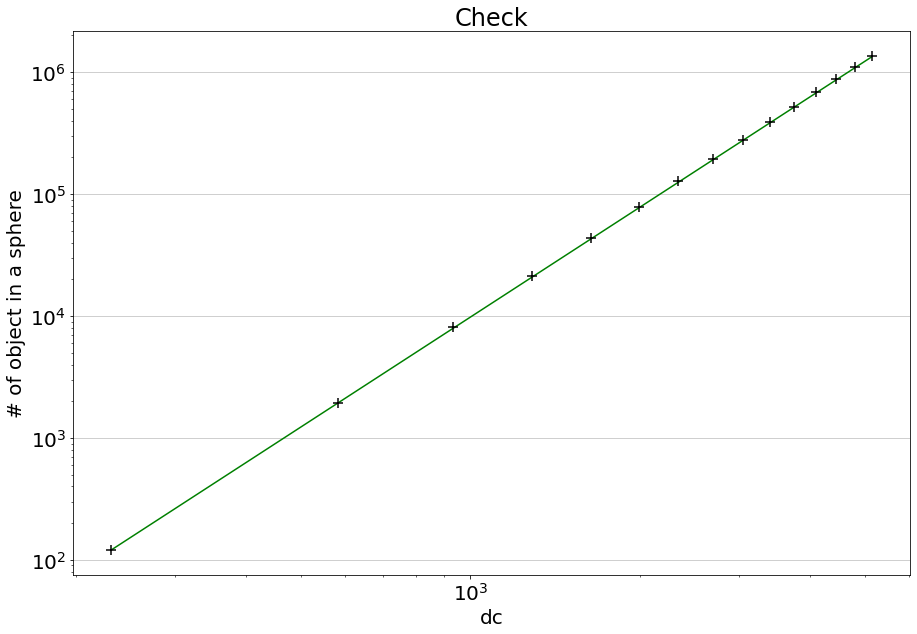

In [42]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,10))
#n, bins, patches = plt.hist(x=numobj,grid=True, bins=Num, rwidth=0.9,color='#607c8e')
plt.xscale('log')
plt.yscale('log')
plt.title('Check')
plt.scatter(position,numobj,s=100, marker='+', c='k', zorder=10 )
plt.plot(position,volume,color='g')
plt.xlabel('dc')
plt.ylabel('# of object in a sphere')
plt.grid(axis='y', alpha=0.75)

Text(0.5, 1.0, 'Phi Dist')

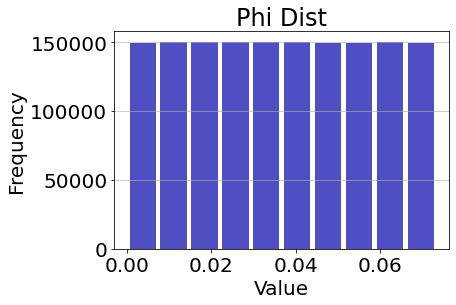

In [43]:
n, bins, patches = plt.hist(x=phi_gals, bins=10, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Phi Dist')

Text(0.5, 1.0, 'Cos Theta dist')

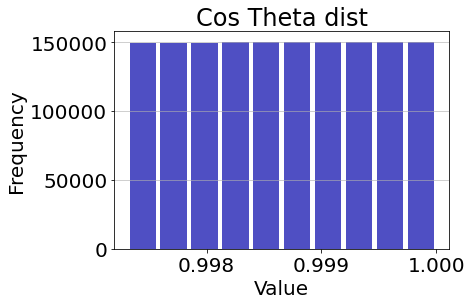

In [44]:
n, bins, patches = plt.hist(x=np.cos(theta_gals), bins=10, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Cos Theta dist')

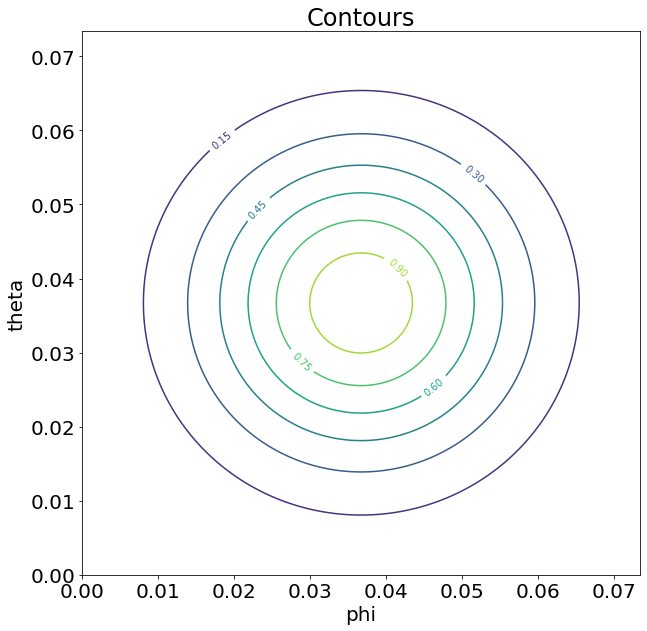

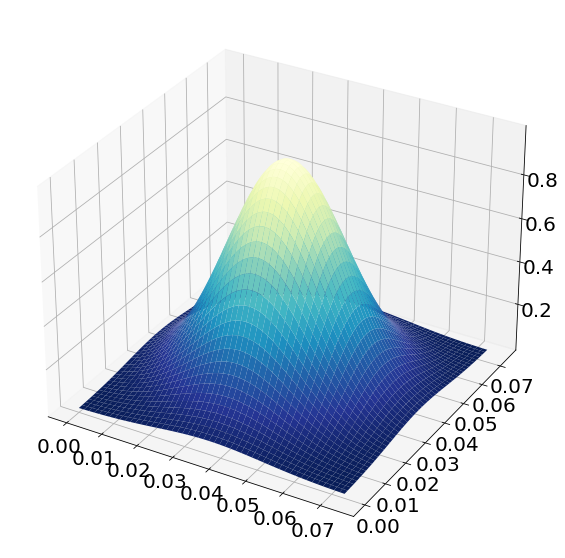

In [45]:
#------------Mises_Fisher-----------------
import matplotlib.cm as cm
point=500

theta_test=np.linspace(theta_min,theta_max,point)
phi_test=np.linspace(phi_min,phi_max,point)
values=np.float128(np.zeros((point,point)))
for i in range(point):
    for j in range(point):
        values[i,j]=sphere_uncorr_gauss(phi_test[i],theta_test[j],DS_phi,DS_theta,sigma_phi,sigma_theta)
X,Y=np.meshgrid(phi_test,theta_test)
Z=values
fig, ax = plt.subplots(1,figsize=(10,10))
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Contours')
ax.set_xlabel('phi')
ax.set_ylabel('theta')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r)


# Computing the likelihood

$$
 L(D_{gw}|H_0)=\frac{1}{\sum_{z_{\alpha}<z_{max} }\omega_{\alpha}}\sum_{\alpha}^{N(R)}\omega_{\alpha}\frac{\rho}{\sqrt{2\pi}\sigma}e^{-\frac{(dl_{\alpha}-\mu)^2}{2\sigma^2}}
$$
$$
\omega_{\alpha}=1; \forall\alpha\,\, \rho=1
$$

In [62]:
arr=np.arange(0,len(H0Grid),dtype=int)
beta=np.zeros(len(H0Grid))
My_Like=np.zeros(len(H0Grid))


In [63]:
def LikeofH0(iterator):
    i=iterator
    Htemp=H0Grid[i]
    #norm=integrate.quad(lambda x:  FlatLambdaCDM(H0=Htemp, Om0=Om0GLOB).differential_comoving_volume(x).value, 0, 10 )[0]
    #----------computing sum
    to_sum=np.zeros(len(z_gals))
    for j in range(len(z_gals)):
        dl=FlatLambdaCDM(H0=Htemp, Om0=Om0GLOB).luminosity_distance(z_gals[j]).value
        angular_prob=sphere_uncorr_gauss(new_phi_gals[j],new_theta_gals[j],DS_phi,DS_theta,sigma_phi,sigma_theta)
        to_sum[j]=likelihood_line(mu,dl,s)*angular_prob#*norm
    tmp=np.sum(to_sum)#*norm
    return tmp
def multibeta(iterator):
    i=iterator
    Htemp=H0Grid[i]
    cosmo=FlatLambdaCDM(H0=Htemp, Om0=Om0GLOB)
    func = lambda z :cosmo.luminosity_distance(z).value - betaHomdMax
    zmax = fsolve(func, 0.6)[0]
    Num=normalisation(z_gals,zmax)
    if Num==0:
        Num=Num+1
    return Num

def vol_beta(iterator):
    i=iterator
    Htemp=H0Grid[i]
    cosmo=FlatLambdaCDM(H0=Htemp, Om0=Om0GLOB)
    func = lambda z :cosmo.luminosity_distance(z).value - betaHomdMax
    zMax = fsolve(func, 0.77)[0]        
    norm = integrate.quad(lambda x: cosmo.differential_comoving_volume(x).value,0,10)[0]
    num = integrate.quad(lambda x:cosmo.differential_comoving_volume(x).value,0,zMax)[0]
    return num/norm

In [64]:
start_time = time.time()
#s=0.01 #to do mixed runs
print('I am Doing my best, please wait...')
with Pool(14) as p:
    My_Like=p.map(LikeofH0, arr)
    beta=p.map(vol_beta, arr)
print("--- %s seconds ---" % (time.time() - start_time))
My_Like=np.asarray(My_Like)
beta=np.asarray(beta)

I am Doing my best, please wait...
--- 2125.4158046245575 seconds ---


In [65]:
Beta=interpolate.CubicSpline(H0Grid,beta)

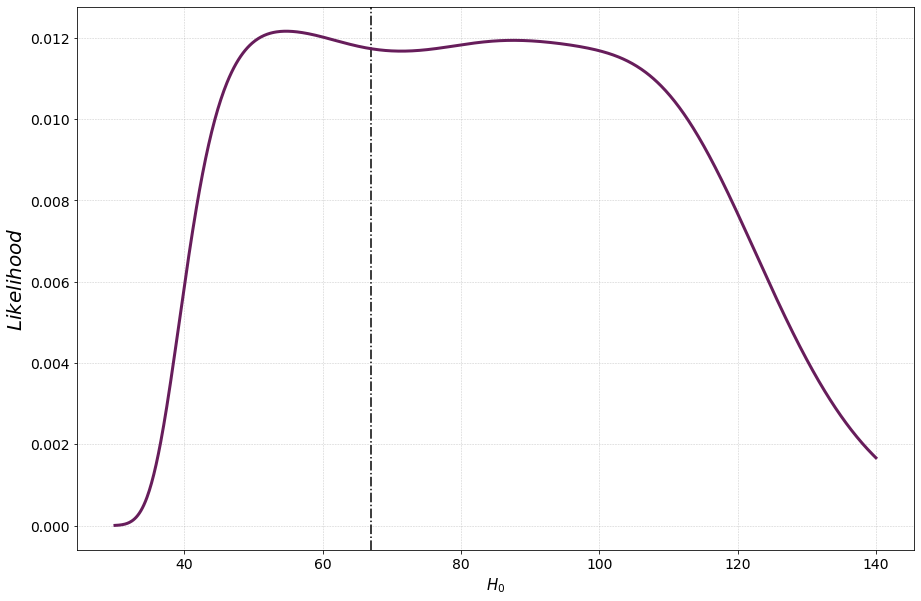

In [66]:
xmin=float(H0Grid[0])
xmax=float(H0Grid[-1])
x=H0Grid
href=67
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlabel(r'$H_0$', fontsize=15)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Likelihood$', fontsize=20)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
#ax.axhline(y=np.max(My_Like)/np.trapz(My_Like,x),color = 'k', linestyle='dashdot')
ax.plot(x,(My_Like/beta)/np.trapz(My_Like/beta,x),label='10% uncertainty',color='#671D5B',
        linestyle='solid',linewidth=3)
#ax.set_ylabel(r'$Beta$', fontsize=20)
#ax.set_xscale('log')
#ax.set_yscale('log')
#data_path='/home/rciancarella/DarkSirensStat/results/GW33_Enzo_sig10samesig_11/'
#os.chdir(data_path)
#xx=np.loadtxt('H0_grid.txt')#x
#event='GW330320'
#bbeta=np.loadtxt(event+'_betaH0.txt')
#ax.plot(x,Beta(x)/Beta(x[0]),label='10% uncertainty',color='#004b49',
#        linestyle='solid',linewidth=3)
#ax.plot(xx,bbeta/bbeta[0],label='10% uncertainty',color='#17EA1E',
#        linestyle='solid',linewidth=3)
#Nice-colours:
#671D5B---violet
#004b49---dark petrol
#17EA1E---Eva01 green

In [67]:
dist=(My_Like/beta)/np.trapz(My_Like/beta,x)
mean=np.trapz(x*dist,x)/np.trapz(dist,x)
std=np.sqrt(np.trapz(dist*(x-mean)**2,x)/np.trapz(dist,x))
#std=np.sqrt(np.sum((My_Like-mean)**2)/len(My_Like))

In [68]:
print('mean={},std={}'.format(mean,std))

mean=83.02692983246077,std=25.663516429521174


In [ ]:
save=0
if save==1:
    res_path='/home/rciancarella/DarkSirensStat/ProxyGenerator'
    os.chdir(res_path)
    np.savetxt('Post_sigma10.txt',dist)
    #np.savetxt('myh0grid.txt',x)